# 1. KITTI 데이터셋 수집과 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    #Train dataset일 경우
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(min_max_height=(300,370), w2h_ratio=370/1242, height=224, width=224, p=0.5),
            Resize(width=224, height=224)
        ])
    #Test dataset일 경우
    return Compose([
        Resize(width=224, height=224)
    ])

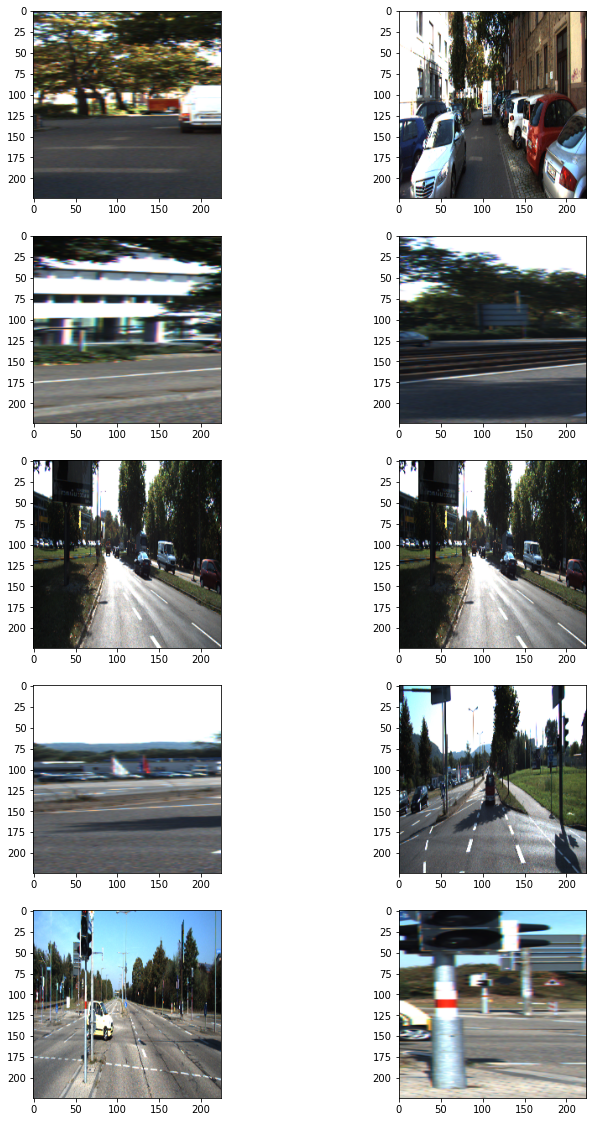

In [3]:
import os

dir_path = os.getenv('HOME') + '/aiffel/Going_Deeper/5.segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, 'image_2', '*.png'))

plt.figure(figsize=(12,20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {'image' : image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized['image'])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed['image'])
    
plt.show()

In [14]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, dir_path, batch_size=4, img_size=(224, 224, 3), output_size=(224,224), is_train=True, augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [15]:
augmentation = build_augmentation()
test_preprocess = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path, augmentation = augmentation)

test_generator = KittiGenerator(dir_path, augmentation = test_preprocess, is_train = False)

# 2. U-Net++ model

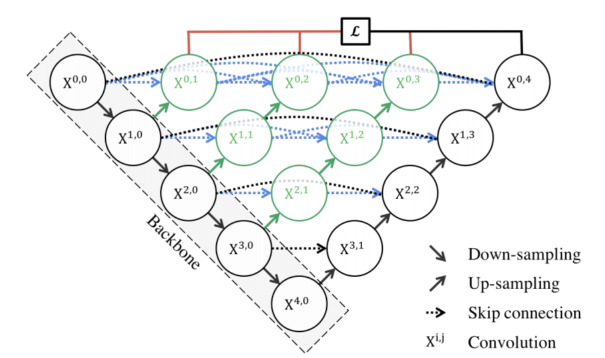

In [16]:
def unet_pp_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #Skip connections
    
    pass1 = conv1
    pass2 = conv2
    pass3 = conv3
    pass4 = conv4
    
    up1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2)
    up2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3)
    up3 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4)
    
    merge01 = concatenate([pass1,up1], axis=3)
    conv01 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge01)
    merge11 = concatenate([pass2,up2], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    merge21 = concatenate([pass3,up3], axis=3)
    conv21 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge21)
    
    up11 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv11)
    merge02 = concatenate([pass1,conv01,up11])
    conv02 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge02)
    up21 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv21)
    merge12 = concatenate([pass2,conv11,up21])
    conv12 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge12)
    
    up12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv12)
    merge03 = concatenate([pass1,conv01,conv02,up12])
    conv03 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge03)
    

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([pass3,conv21,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([pass2,conv11,conv12,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([pass1,conv01,conv02,conv03,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
    
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model


In [17]:
model_plus_path = os.getenv('HOME') + 'aiffel/Going_Deeper/5.segmentation/unet_pp.h5'

model_plus = unet_pp_model()
model_plus.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy')
model_plus.fit_generator(generator=train_generator,
                   validation_data = test_generator,
                   steps_per_epoch = len(train_generator),
                   epochs = 100
                   )

model_plus.save(model_plus_path)

Epoch 1/100
43/43 [==============================] - 64s 1s/step - loss: 0.5868 - val_loss: 0.1192
Epoch 2/100
43/43 [==============================] - 61s 1s/step - loss: 0.1155 - val_loss: 0.1210
Epoch 3/100
43/43 [==============================] - 62s 1s/step - loss: 0.1160 - val_loss: 0.1466
Epoch 4/100
43/43 [==============================] - 62s 1s/step - loss: 0.1312 - val_loss: 0.1097
Epoch 5/100
43/43 [==============================] - 61s 1s/step - loss: 0.0993 - val_loss: 0.0913
Epoch 6/100
43/43 [==============================] - 61s 1s/step - loss: 0.0957 - val_loss: 0.0915
Epoch 7/100
43/43 [==============================] - 61s 1s/step - loss: 0.0719 - val_loss: 0.0875
Epoch 8/100
43/43 [==============================] - 61s 1s/step - loss: 0.0734 - val_loss: 0.0857
Epoch 9/100
43/43 [==============================] - 61s 1s/step - loss: 0.0741 - val_loss: 0.0765
Epoch 10/100
43/43 [==============================] - 61s 1s/step - loss: 0.0736 - val_loss: 0.0786
Epoch 11/

# 3. Semantic Segmentation Model Visualization

In [18]:
#model_plus_path = dir_path + '/unet_pp.h5'
model_plus = tf.keras.models.load_model(model_plus_path)

In [19]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

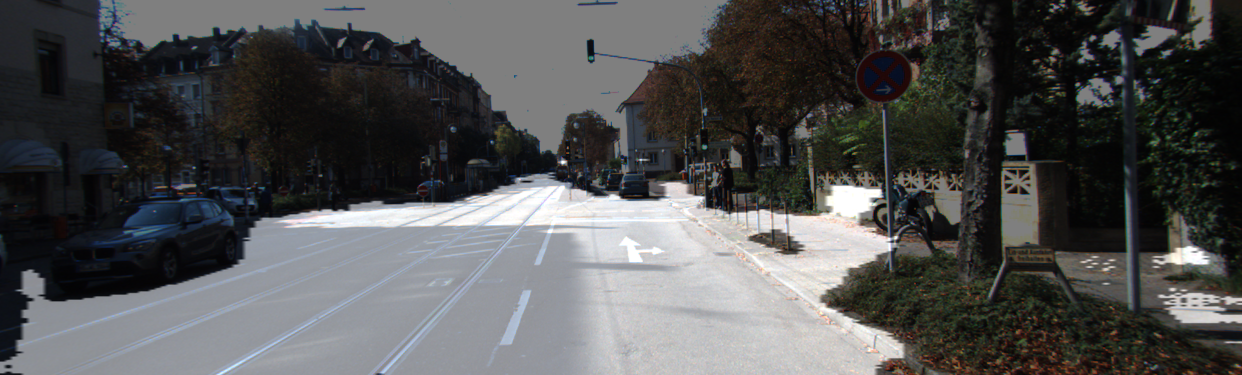

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model_plus, 
     test_preprocess,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [21]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [22]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [23]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_plus, 
     test_preprocess,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.830606


0.8306059568640877

# 회고

- Model 구현에서 조금 고생을 했다. 논문에서 non-padding이라 나와있고, 그림을 봐도 zero padding을 하지 않아 이미지 사이즈가 주는 것을 볼 수 있지만, model 구현 시 padding='valid'로 해서 구현을 했을 때 사이즈가 안 맞는 문제가 당연히 있었고, 그 문제를 resize를 이용해 summary까지 찍히는걸 확인했지만 이미지 학습에서 문제가 계속 생겼다. 일단 zero padding을 이용해 U-Net과 U-Net++를 구현했지만 추후에 더 공부를 하여 논문에서 요구하는대로 구현을 해야겠다.   

- U-Net++ 는 U-Net보다 모델 학습시간이 오래 걸렸다. 하지만 그만큼 IoU가 높게 나왔다. 모델에서 요구한대로 구현하지는 못 했지만 그래도 더 좋은 성능이 나왔으니 기분은 좋다.